In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers, losses, activations, models
import cv2
import os


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 184

In [12]:
def datafunc(data_dir):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels_list.append(class_num)
            except Exception as e:
                print(e)

    return np.array(images), np.array(labels_list)

In [13]:
train_images, train_labels = datafunc('Dataset/chest_xray/chest_xray/train')
test_images, test_labels = datafunc('Dataset/chest_xray/chest_xray/test')
val_images, val_labels = datafunc('Dataset//chest_xray/chest_xray/val')

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



/home/rasool/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


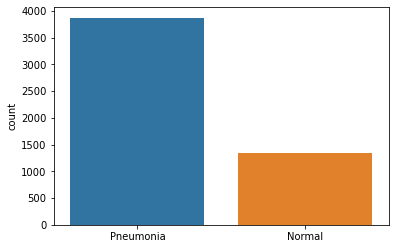

In [15]:
train_labels_str = ['Pneumonia' if label == 0 else 'Normal' for label in train_labels]

sns.countplot(train_labels_str)
plt.show()

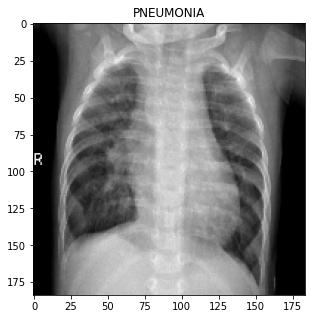

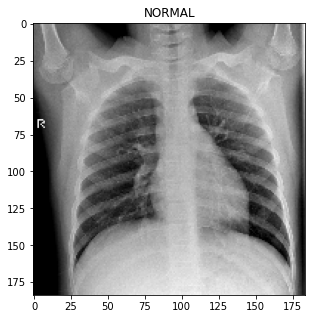

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')
plt.title(labels[train_labels[0]])

plt.figure(figsize=(5, 5))
plt.imshow(train_images[-1], cmap='gray')
plt.title(labels[train_labels[-1]])

plt.show()

In [18]:
x_train = train_images
y_train = train_labels

x_val = val_images
y_val = val_labels

x_test = test_images
y_test = test_labels

In [19]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0
x_val = np.array(x_val)/255.0


In [20]:
x_train = (x_train.reshape(-1,img_size,img_size,3))
x_test = (x_test.reshape(-1,img_size,img_size,3))
x_val = (x_val.reshape(-1,img_size,img_size,3))
x_train.shape

(5216, 184, 184, 3)

In [21]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

# Feature Extraction

In [22]:
base_model = keras.applications.VGG19(weights='imagenet', 
                                include_top=False, 
                                input_shape=(184,184,3))
base_model.trainable = False

In [23]:
x = base_model.output
x= Flatten()(x)
x = Dense(4096, activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
x= Dense(4096,activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
for layer in base_model.layers:
    layer.trainable = False

In [28]:
model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/home/rasool/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 184, 184, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 184, 184, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 184, 184, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 92, 92, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 92, 92, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 92, 92, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 46, 46, 128)       0   

In [30]:
datagen= ImageDataGenerator(zoom_range=0.2)

In [31]:
datagen.fit(x_train)

In [33]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 5 , validation_data = datagen.flow(x_test, y_test))

Epoch 1/5
82/82 [==============================] - 39s 451ms/step - loss: 0.4606 - accuracy: 0.8533 - val_loss: 0.4544 - val_accuracy: 0.8269
Epoch 2/5
82/82 [==============================] - 39s 470ms/step - loss: 0.4203 - accuracy: 0.8645 - val_loss: 0.4757 - val_accuracy: 0.7965
Epoch 3/5
82/82 [==============================] - 49s 593ms/step - loss: 0.3424 - accuracy: 0.8901 - val_loss: 0.3597 - val_accuracy: 0.8734
Epoch 4/5
82/82 [==============================] - 52s 631ms/step - loss: 0.3516 - accuracy: 0.8850 - val_loss: 0.3240 - val_accuracy: 0.8910
Epoch 5/5
82/82 [==============================] - 55s 674ms/step - loss: 0.3088 - accuracy: 0.9007 - val_loss: 0.3096 - val_accuracy: 0.8942


# Fine Tunning

In [34]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [35]:
for layer in model.layers[:12]:
    layer.trainable = False
for layer in model.layers[12:]:
    layer.trainable = True

In [36]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [37]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

In [40]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 5 , validation_data = datagen.flow(x_test, y_test),callbacks=[early])


Epoch 1/5
82/82 [==============================] - 48s 576ms/step - loss: 0.3060 - accuracy: 0.9039 - val_loss: 0.4596 - val_accuracy: 0.8510
Epoch 2/5
82/82 [==============================] - 51s 623ms/step - loss: 0.2547 - accuracy: 0.9212 - val_loss: 0.3578 - val_accuracy: 0.8830
Epoch 3/5
82/82 [==============================] - 64s 775ms/step - loss: 0.2131 - accuracy: 0.9356 - val_loss: 0.3701 - val_accuracy: 0.9071
Epoch 4/5
82/82 [==============================] - 79s 956ms/step - loss: 0.1828 - accuracy: 0.9465 - val_loss: 0.4195 - val_accuracy: 0.8638
Epoch 5/5
82/82 [==============================] - 82s 1000ms/step - loss: 0.1575 - accuracy: 0.9517 - val_loss: 0.3331 - val_accuracy: 0.8926


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


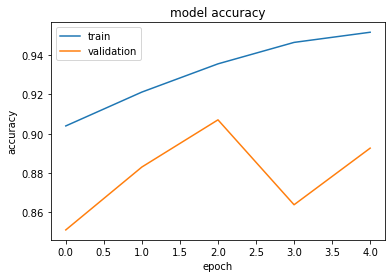

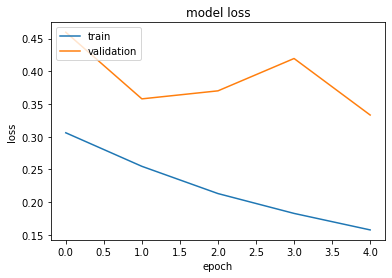

In [41]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [42]:
predictions = model.predict(x_test)
predictions = predictions[:,0]
i=0
for i in range(len(predictions)):
    if predictions[i]>0.65:
        predictions[i]=0
    else:
        predictions[i]=1

20/20 [==============================] - 3s 167ms/step


<AxesSubplot:>

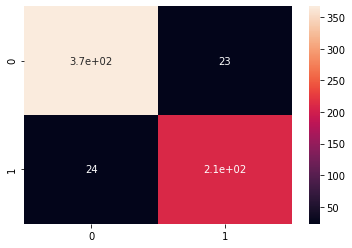

In [43]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True)
